In [1]:
from glove import Corpus, Glove
from nltk.corpus import stopwords
import pandas as pd
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import warnings

import numpy as np
from numpy import dot
from numpy.linalg import norm
from numpy import linalg as LA
from statistics import mean
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import matplotlib.cm as cm

wordnet_lemmatizer = WordNetLemmatizer()
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 
matplotlib_axes_logger.setLevel('ERROR')
warnings.filterwarnings("ignore")

## Train the model

In [2]:
main_dataset = pd.read_csv(r'..\data\main_dataset.csv', encoding = 'utf8')
#main_dataset['new_text'] = main_dataset['classification'] + ' ' + main_dataset['text']

In [4]:
lines = list(main_dataset['text'])
new_lines=[]
seperated_lines = []
for line in lines:
    try:
        new_lines=line.split(' ')
    except:
        continue
    seperated_lines.append(new_lines)
lines = seperated_lines

stop_words= set(stopwords.words('english')) 
lines_without_stopwords=[]

# remove stop words and lematize
lines2 = list()
for ln in lines:
    temp_line = list()
    for word in ln:
        if word not in stop_words: 
            temp_line.append(wordnet_lemmatizer.lemmatize(word))
    string= ' '
    lines2.append(string.join(temp_line))
lines = lines2

new_lines=[] 
for line in lines:
    n_lines = [x for x in line.split(' ') if x]
    new_lines.append(n_lines) #new lines has the new format

Fitting the model

In [4]:
corpus = Corpus()
corpus.fit(new_lines, window=10)

In [6]:
glove = Glove(no_components=300, learning_rate=0.05)

In [7]:
# No need to train the model, as we have already trained it - proceed to next cell
glove.fit(corpus.matrix, epochs=100, no_threads=200, verbose=True)

Performing 100 training epochs with 200 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [8]:
glove.add_dictionary(corpus.dictionary)

Our dataset is not clean enough - manually write in the txt file

In [10]:
# This cell can also be skipped as we have added our model to GDrive
with open("../models/trained_glove_300.txt", "w") as f:
    for word in glove.dictionary:
        try:
            f.write(word)
            f.write(" ")
            for i in range(0, 300):
                f.write(str(glove.word_vectors[glove.dictionary[word]][i]))
                f.write(" ")
            f.write("\n")
        except:
            continue

### Loading trained model

In [2]:
def loadGloveModel(File):
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        if len(splitLines) <= 1:
            continue
        word = splitLines[0]
        if any(map(str.isdigit, word)):
            #print(word)
            continue
        try:
            wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        except:
            continue
        gloveModel[word] = wordEmbedding
    return gloveModel

In [3]:
# The file 'trained_glove_300.txt' can be found in the folder 'Trained_Glove_model' in our GDrive.
glove_300 = loadGloveModel('../models/trained_glove_300.txt')

### Analysis

In [4]:
embedding_clusters = []
word_clusters = []

TOP_N = 30
KEYS = { \
    "offensive": set(),
    "abusive": set(),
    #"cyberbullying": set(), 
    "vulgar": set(), 
    "racist": set(), 
    "homophobic": set(), 
    "profane": set(), 
    "slur": set(), 
    "harrasment": set(), 
    "obscene": set(), 
    "threat": set(), 
    "discredit": set(), 
    "hateful": set(), 
    "insult": set(), 
    "hostile": set(),
    # adding another one - sexist    
    "sexist": set()
}
FIXED_KEYS = list(KEYS.keys())

for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'offensive': {'offens', 'offensive'},
 'abusive': {'abus', 'abusive'},
 'vulgar': {'vulgar'},
 'racist': {'racist'},
 'homophobic': {'homophob', 'homophobic'},
 'profane': {'profan', 'profane'},
 'slur': {'slur'},
 'harrasment': {'harras', 'harrasment'},
 'obscene': {'obscen', 'obscene'},
 'threat': {'threat'},
 'discredit': {'discredit'},
 'hateful': {'hate', 'hateful'},
 'insult': {'insult'},
 'hostile': {'hostil', 'hostile'},
 'sexist': {'sexist'}}

In [5]:
def cosine_similarity(a, b):
    return dot(a, b)/(LA.norm(a) * LA.norm(b))

def most_similar_word(a, number = 5):
    words = list()
    for vec in glove_300:
        #sometimes vector is too long
        try:
            words.append((vec, cosine_similarity(glove_300[vec], a)))
        except:
            continue
    return list(reversed(sorted(words, key=lambda tup: tup[1])))[:number]

def word_analogy(paris, france, berlin):
    vecc = glove_300[france] - glove_300[paris] + glove_300[berlin] 
    return most_similar_word(vecc)

In [7]:
def getSimilarWords(model_gn):
    embedding_clusters = list()
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in most_similar_word(glove_300[key], number=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(np.array(glove_300[similar_word]))
                #print(f'Added {similar_word} for key {key}')

        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")

        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]

        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    return (word_clusters, embedding_clusters)

def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
    return False

In [8]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)
    
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)
    
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)
    
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)
    
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [9]:
word_clusters, embedding_clusters = getSimilarWords(glove_300)

{'offens', 'offensive'} -- offensive
{'abus', 'abusive'} -- abusive
{'vulgar'} -- vulgar
{'racist'} -- racist
{'homophob', 'homophobic'} -- homophobic
{'profane', 'profan'} -- profane
{'slur'} -- slur
{'slur'} -- slur.
{'slur'} -- slur,
{'harras', 'harrasment'} -- harrasment
{'obscene', 'obscen'} -- obscene
{'threat'} -- threat
{'discredit'} -- discredit
{'hateful', 'hate'} -- hateful
{'insult'} -- insult
{'hostil', 'hostile'} -- hostile
{'sexist'} -- sexist
{'sexist'} -- sexist,
{'sexist'} -- sexist.


In [10]:
displayDF(word_clusters)

,offensive,abusive,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile,sexist
0,nigger....but,behavior,.....lol,#jewcracy:,dyke????,bwahahahahahah,insults.,‘campaigning,deemed,reatment,CatPurrr!,democrats.,"injury,",backboard,"prejudiced,"
1,classic?,underscoring,"entertaining,","#ApartheidIsrael,",Lilly:,#SXSW,racial,JOKE',Hispanics”,interstate,seatbelt,"cunts,",'behead,Arab/Muslim,Extremely
2,playcalling,reporting,"systems,",fraud..............and,chauvinist?,sumn...ANYTHING,petty,*doesn’,Koozy,Pabst,Ibaka,cruel,Islam),gayness,chauvinist?
3,vulgar,exhibited,"fcuk.""","moron.\nFU!""","#ApartheidIsrael,",gang!,midst,Mcinnes,#CraftCannabis,death,lastead,creatures.,'dyke',purposefully,"#ApartheidIsrael,"
4,substitute,tribe',putback,morrissey,"midwestern,",#ojoro,alien..drive,"""queer",cunt....red,"community/market,",bunk,conduct.,"""Kike""","HuffPo,",homophobic
5,McStain.,Mindless,unheard,emplayee,"myth"",",Salvation?,"""retard"".",unconsented,schoolgirl,(mis)perceived,doubting,blanket,superchat,ann,emplayee
6,milly.ctd,"key!,",sentence:,"myth"",",morrissey,"opinion""","segregation,","non-migrant,",trash.”,looming,"words,has","Carl,",‘hillbilly’,pestering,"biased,"
7,oray,"Rift,",misleading.,virulently,Jee,#Manginas,lover?,'suspected,extermination,"six,",Kappy.,act.,Alonso,cummin,fraud..............and
8,fantastic.,dyke????,offensive,pariya,misogynist,extinct..,PHILOSOPHER,judaism;,forcible,“potential”,-are,rhetoric.,(fill,normalize,virulently
9,drugs?,sectarian,"+=~~.~~!""",larper/actual,#jewcracy:,(ppl,discrimination.,"rational!""",#zioNaZi,gatekept,Allum',highlighted,economy¿,/drawn,mysogynistic


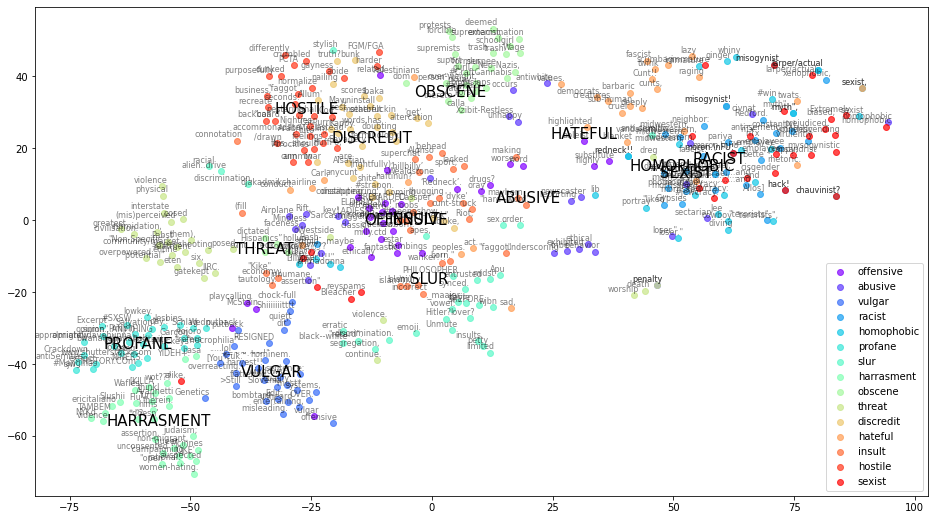

In [11]:
plotTSNE("", word_clusters, embedding_clusters, "SimilarWordsTSNE_train.png");

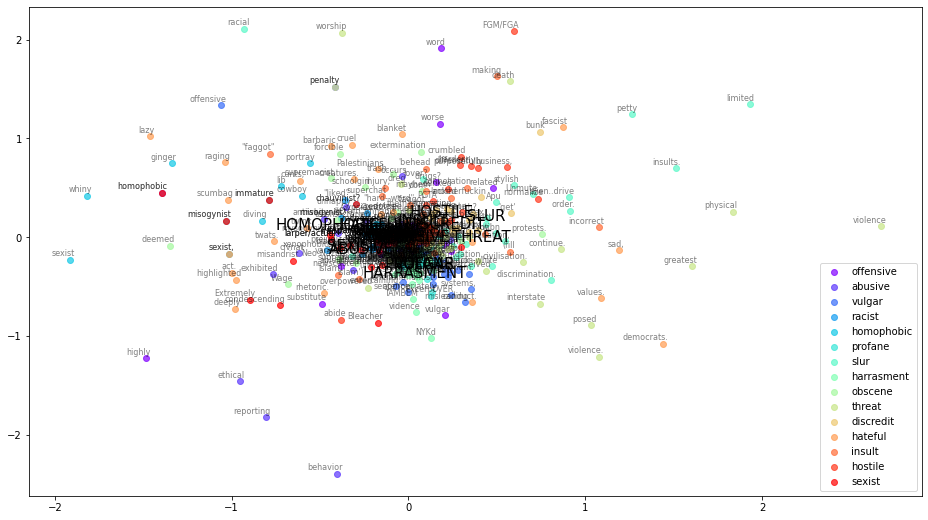

In [12]:
plotMDS("", word_clusters, embedding_clusters, "SimilarWordsMDS_train.png")

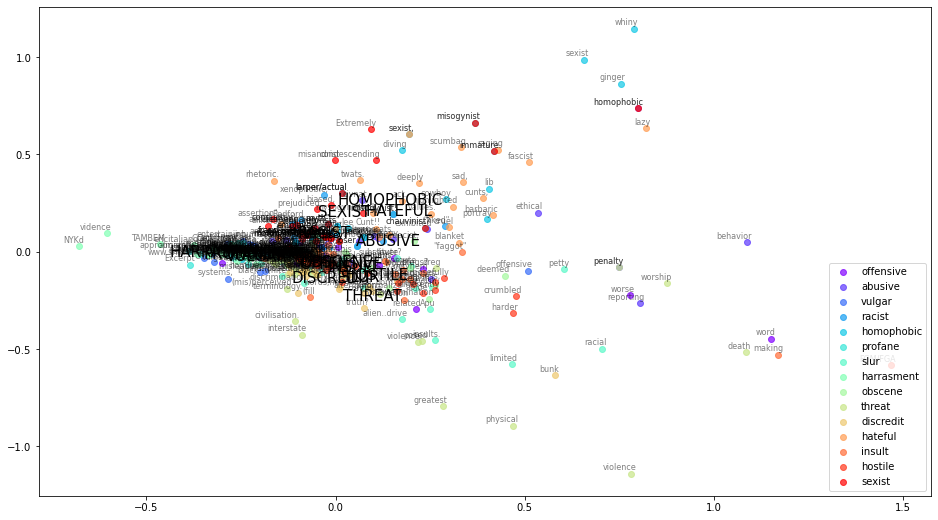

In [13]:
plotPCA("", word_clusters, embedding_clusters, "SimilarWordsPCA_train.png")

### Word analogy

In [14]:
word_analogy('black', 'nigger', 'white')[1:]

[('Anti-FirstAmendment', 0.6060632646482942),
 ('dumpsterjuice', 0.5968376058288242),
 ('(travestie)', 0.588917701558929),
 ('Omg', 0.5851099944594712)]

In [15]:
word_analogy('white', 'trash', 'black')[1:]

[("arizona'", 0.9310544891594585),
 ('(trump)', 0.9237034633740399),
 ('outfit.”', 0.9197108093695575),
 ('thunderstruck.', 0.9161690848953526)]

In [ ]:
word_analogy('cool', 'obama', 'trump')[1:]